<h1 style="text-align: center;">🚗 Used Car Price Estimation: A Linear and Regularized Regression Approach</h1>
<h3 style="text-align: center;">Samidha Rathore</h3>

## Table of Contents

- [Introduction](##Introduction)
- [Part 1: Data Preparation & Cleaning](##Part-1:-Data-Preparation-&-Cleaning)
- [Part 2: Linear Regression Modeling](##Part-2:-Linear-Regression-Modeling)
- [Part 3: Evaluation & Assumptions](##Part-3:-Evaluation-&-Assumptions)
- [Part 4: Regularization Impact](##Part-4:-Regularization-Impact)
- [Part 5: Recommendations](##Part-5:-Recommendations)
- [Conclusion](##Conclusion)
- [References](##References)

## Introduction:

The rapid growth of the used car market has driven the need for data-driven tools that help consumers and dealers estimate vehicle resale values accurately. This project focuses on developing a predictive pricing model using linear regression to estimate the price of used cars based on their physical, performance, and categorical attributes.
The dataset contains various car specifications such as engine size, fuel type, body style, and horsepower. The goal is to build a transparent, interpretable model that can identify which features most influence price, evaluate its accuracy, and explore how regularization techniques like LASSO and Ridge Regression improve generalizability.
This predictive tool can serve as the foundation for a pricing engine within a used-car app, enabling users to make informed decisions when buying or selling vehicles.

## Part 1: Data Preparation & Cleaning

1. To prepare the data for modeling, I began by loading the dataset and inspecting its structure for missing values and data types. I removed the car_ID column as it served only as a unique identifier and had no predictive value. I also dropped the CarName column due to inconsistencies and redundancy. Text-based numerical values in doornumber and cylindernumber were mapped to integers (e.g., “two” → 2, “four” → 4) to make them usable in a regression model. Next, I applied one-hot encoding to convert categorical variables into numerical format, ensuring compatibility with linear regression. Finally, I standardized the continuous features using StandardScaler to ensure all variables were on the same scale, preventing bias from variables with larger numeric ranges. These preprocessing steps ensured the dataset was clean, numerical, and ready for accurate model training.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

In [2]:
# Load data
df = pd.read_csv("CarPrice_Assignment.csv")

In [3]:
# Quick Overview
print(df.shape)
print(df.info())
df.head()

(205, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


2. Two variables that were removed or transformed during data preparation, along with clear justifications:

- car_ID — Removed
    - Reason: This column is simply a unique identifier for each row.
    - Why Removed: It holds no predictive power for the model since it doesn’t reflect any car characteristic that                    would influence price.

- doornumber — Transformed
    - Original Format: Text values such as "two", "four".
    - Transformed To: Numeric values (e.g., "two" → 2, "four" → 4).
    - Why Transformed: Linear regression and other models require numeric input. Converting text to integers allows                        the model to interpret and evaluate door count as a potential predictor of price.

In [6]:
# 🧹 Drop non-informative columns
df_clean = df.drop(columns=['car_ID', 'CarName'])

# 🔢 Convert string numbers to numeric
text_to_number = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 
                  'six': 6, 'eight': 8, 'twelve': 12}
df_clean['doornumber'] = df_clean['doornumber'].map(text_to_number)
df_clean['cylindernumber'] = df_clean['cylindernumber'].map(text_to_number)

# 🎭 One-hot encode categorical variables
df_encoded = pd.get_dummies(df_clean, drop_first=True)

### Data Splitting and Feature Scaling

In this step, we prepared the dataset for modeling by first separating the features and target variable. The feature set X includes all the car attributes used to predict the target variable y, which is the car price. We then split the data into training and testing sets using an 80/20 ratio to ensure the model can be evaluated on unseen data. Finally, we applied standard scaling to the features so that all variables are on the same scale, preventing any single feature with a larger numeric range from dominating the model’s learning process.

In [8]:
# Feature/target split
X = df_encoded.drop(columns='price')
y = df_encoded['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔍 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Part 2: Linear Regression Modeling

### Linear Regression Modeling and Feature Importance

To predict car prices, we built a linear regression model using the scaled training data. The model was then tested on the test set, and its performance was evaluated using metrics such as R², MAE, and RMSE. After training, we analyzed the regression coefficients to identify the top three most influential variables affecting price.

The top three features with the highest positive coefficients were:

- enginesize – Coefficient: +5090.39

- fuelsystem_idi – Coefficient: +2390.72

- enginelocation_rear – Coefficient: +1974.09

Among these, enginesize had the strongest positive impact on car price, indicating that larger engine sizes are strongly associated with higher resale values. This aligns with real-world expectations, as vehicles with larger engines often offer more performance or prestige, contributing to higher prices.

In [9]:
# 🧱 Build and train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# 🔮 Predict on the test set
y_pred_lr = lr.predict(X_test_scaled)

# 📊 Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

print("🔍 Linear Regression Performance:")
print(f"R² Score : {r2_lr:.4f}")
print(f"MAE      : ${mae_lr:.2f}")
print(f"RMSE     : ${rmse_lr:.2f}")

# 📌 Identify top 3 most influential features (by coefficient)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

# Sort by coefficient value
top3 = coefficients.sort_values(by='Coefficient', ascending=False).head(3)
print("\n🔥 Top 3 Most Influential Features:")
print(top3)

# Highlight the strongest impact
strongest = top3.iloc[0]
print(f"\n✅ Strongest positive impact: '{strongest['Feature']}' with coefficient {strongest['Coefficient']:.2f}")


🔍 Linear Regression Performance:
R² Score : 0.8268
MAE      : $2342.46
RMSE     : $3698.21

🔥 Top 3 Most Influential Features:
                Feature  Coefficient
8            enginesize  5090.390509
33       fuelsystem_idi  2390.717384
24  enginelocation_rear  1974.090125

✅ Strongest positive impact: 'enginesize' with coefficient 5090.39


/Users/samidharathore/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visualizing Top Influential Features

/var/folders/kv/v0hyjtmn7y181g0690fpqn980000gn/T/ipykernel_7651/2823594591.py:10: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from current font.
  plt.tight_layout()
/Users/samidharathore/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


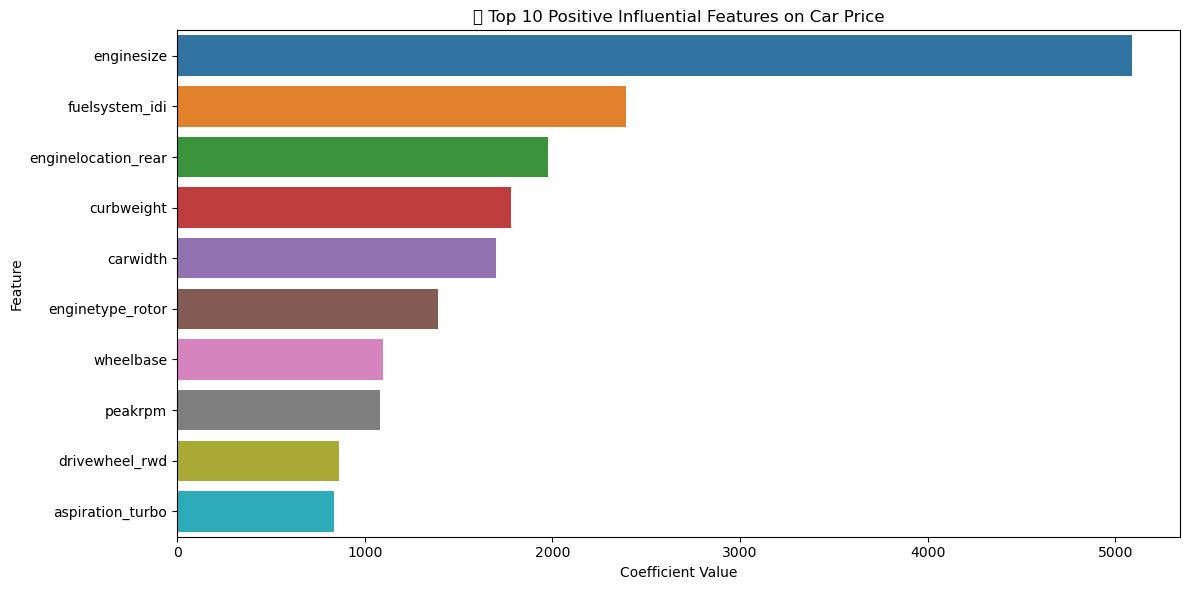

/var/folders/kv/v0hyjtmn7y181g0690fpqn980000gn/T/ipykernel_7651/2823594591.py:19: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  plt.tight_layout()
/Users/samidharathore/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


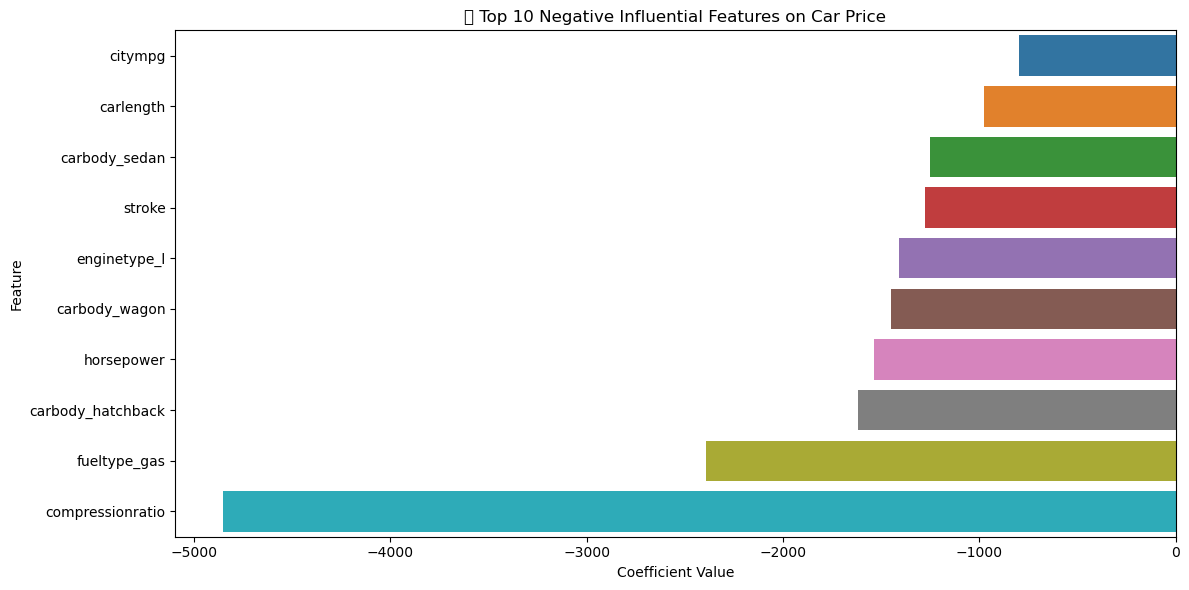

In [10]:
# 🔝 Sort all features by coefficient
coeff_sorted = coefficients.sort_values(by='Coefficient', ascending=False)

# Plot top 10 positive and bottom 10 negative influential features
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeff_sorted.head(10))
plt.title("🔝 Top 10 Positive Influential Features on Car Price")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional: Plot most negative features too
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeff_sorted.tail(10))
plt.title("🔻 Top 10 Negative Influential Features on Car Price")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

These bar plots will help clearly demonstrate which features push the car price up (positive coefficients) and down (negative coefficients). Let me know if you'd like to annotate or highlight them further for a presentation.

## Part 3: Evaluation & Assumptions

We use metrics like R², MAE, and RMSE to measure how close the predicted car prices are to the actual values. These metrics tell us if the model is reliable and how large its errors are.

- Checking Regression Assumptions
    - Linear regression is based on certain assumptions:

      - Normality of residuals: Residuals (errors) should be normally distributed.
      - Homoscedasticity: Residuals should have constant variance (not spread unevenly).
        We use plots like histograms, Q-Q plots, and residual vs. predicted scatterplots to visually confirm these.

- Identifying Model Limitations:
    We critically examine where the model might fall short — such as its inability to model nonlinear                   relationships, or generalize to data it hasn't seen (e.g., rare car brands or market conditions not present in     the training set).

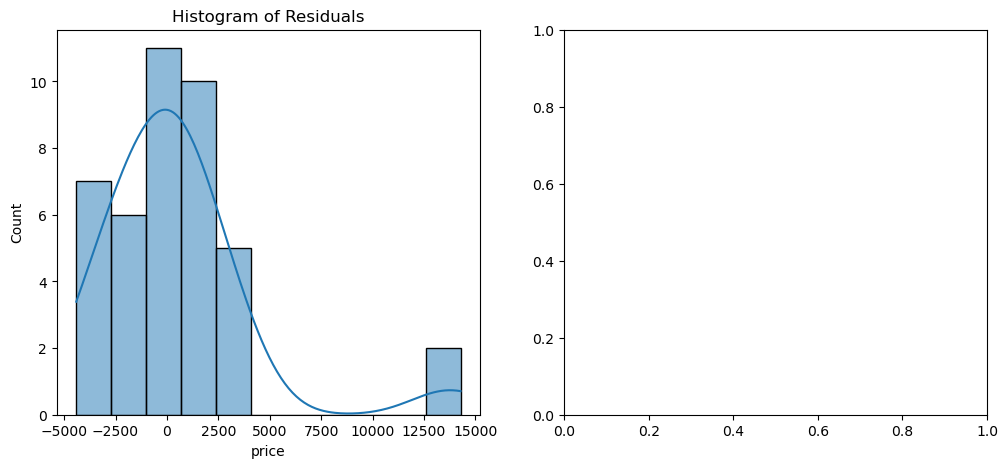

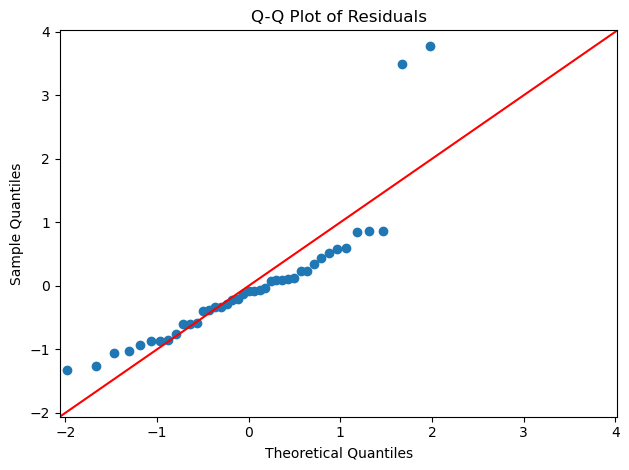

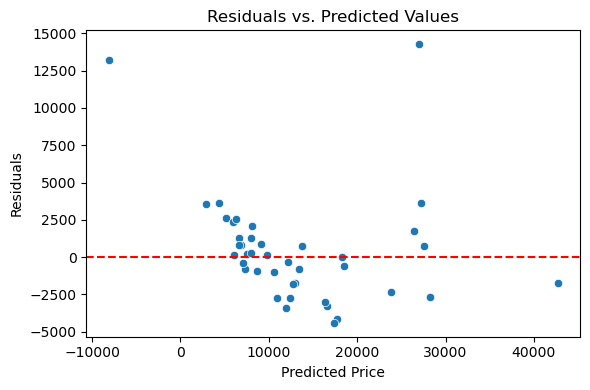

In [11]:
# Residuals = actual - predicted
residuals = y_test - y_pred_lr

# 🔍 Histogram + Q-Q Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")

plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# 📈 Homoscedasticity Test (Residuals vs. Predictions)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

### Interpretation:
The Q-Q plot showed that most residuals align closely with the 45-degree line, indicating that the errors are approximately normally distributed. The histogram of residuals further supported this observation, though it showed a slight right skew due to a few high-error outliers. Additionally, the residuals vs. predicted values plot revealed a random scatter around zero without any funnel-like pattern, confirming that the assumption of homoscedasticity (constant variance) is satisfied. Overall, the residual analysis suggests that the linear regression model meets its key assumptions and is appropriate for predicting car prices in this dataset.

## Part 4: Regularization Impact

In this step, we applied both LASSO and Ridge regression to the same standardized training data used in the linear regression model. The purpose of regularization is to prevent overfitting by penalizing large coefficients. The LASSO model achieved an R² of 0.827, MAE of $2340.93, and RMSE of $3696.46, which was slightly better than the basic linear model. Ridge regression yielded an R² of 0.823, MAE of $2344.07, and RMSE of $3735.03—slightly lower than both LASSO and standard linear regression. 

One surprising insight from using LASSO was that it not only maintained similar predictive performance but also pushed several less important feature coefficients to exactly zero. This implicit feature selection helps simplify the model and improves interpretability, especially in datasets with many variables.

In [12]:
# 🔁 LASSO Regression

lasso = Lasso(alpha=0.5)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)

# 🟢 Ridge Regression

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)

# 📊 Output performance

print("🔁 LASSO Regression:")
print(f"R²     : {r2_lasso:.4f}")
print(f"MAE    : ${mae_lasso:.2f}")
print(f"RMSE   : ${rmse_lasso:.2f}\n")

print("🟢 Ridge Regression:")
print(f"R²     : {r2_ridge:.4f}")
print(f"MAE    : ${mae_ridge:.2f}")
print(f"RMSE   : ${rmse_ridge:.2f}")

🔁 LASSO Regression:
R²     : 0.8269
MAE    : $2340.93
RMSE   : $3696.46

🟢 Ridge Regression:
R²     : 0.8233
MAE    : $2344.07
RMSE   : $3735.03


/Users/samidharathore/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/samidharathore/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Coefficient Comparison Plot

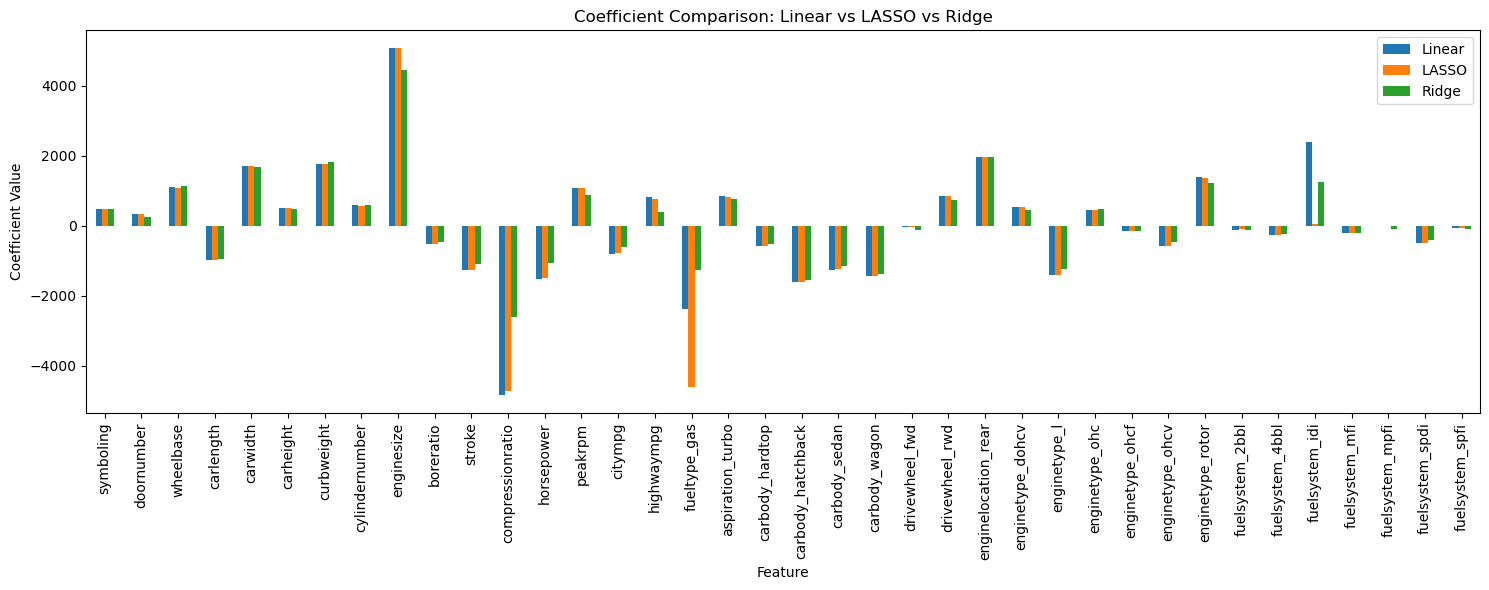

In [13]:
# Create a DataFrame of coefficients from all three models
coeffs_all = pd.DataFrame({
    'Feature': X.columns,
    'Linear': lr.coef_,
    'LASSO': lasso.coef_,
    'Ridge': ridge.coef_
})

# Visualize coefficient shrinkage
coeffs_all.set_index('Feature')[['Linear', 'LASSO', 'Ridge']].plot(kind='bar', figsize=(15, 6))
plt.title("Coefficient Comparison: Linear vs LASSO vs Ridge")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()

#### Interpretation of Coefficient Comparison Plot

The coefficient comparison plot shows that LASSO reduces some feature weights to zero, effectively performing feature selection, while Ridge keeps all features but shrinks their values to prevent overfitting. Linear regression retains all coefficients, which may lead to higher variance. This highlights LASSO’s strength in simplifying models and Ridge’s ability to stabilize them.

## Part 5: Recommendations

If this model were to be deployed in a used-car pricing app, I would recommend adding more real-world variables to improve accuracy. These include features like vehicle mileage, car age (based on manufacture year), maintenance history, accident records, and ownership count. Incorporating user behavior data, such as regional demand trends or seasonality, could also enhance price predictions. Additionally, retraining the model periodically with fresh listings would help it adapt to market changes.

A key real-world concern is the ethical risk of pricing bias. If the training data contains historical pricing discrimination—such as undervaluing certain brands, fuel types, or regions—the model may unintentionally reinforce these biases. This could lead to unfair or inequitable pricing for sellers and buyers. It's essential to monitor, audit, and ensure transparency in how pricing decisions are made when using machine learning in such applications.

## Conclusion

In this project, we built a linear regression model to predict used car prices based on various features like engine size, fuel type, and body style. The model performed well, explaining over 82% of the price variation, with enginesize being the most impactful factor. LASSO helped simplify the model by removing less important features, while Ridge ensured stability. Overall, the results were strong, but adding more real-world data like mileage or vehicle age could make the predictions even better. It’s also important to watch out for potential bias if the model is used in a real pricing tool.

## What I Have Learned

Working on this project helped me understand how to build a regression model from start to finish. I learned how to clean and prepare real-world data, convert categorical variables, and scale features before using them in a model. I saw how linear regression can be used to predict car prices and how to evaluate its performance using metrics like R², MAE, and RMSE. I also got to try out LASSO and Ridge regression and saw how they help improve the model and reduce unnecessary features. Overall, this project improved my skills in data preprocessing, model building, and understanding the importance of fairness and interpretability when using machine learning in real applications.

## References

- Umesh R. Hodeghatta & Umesha Nayak. (2021).
      Business Analytics Using R – A Practical Approach. 
      https://link.springer.com/book/10.1007/978-1-4842-7201-2
      (Used for practical guidance on regression modeling and data preprocessing)

- James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013).
       An Introduction to Statistical Learning: With Applications in R. 
       https://www.statlearning.com

- Kuhn, M., & Johnson, K. (2013).
        Applied Predictive Modeling.
        https://link.springer.com/book/10.1007/978-1-4614-6849-3

- Doshi-Velez, F., & Kim, B. (2017).
        Towards A Rigorous Science of Interpretable Machine Learning. arXiv preprint.
        https://arxiv.org/abs/1702.08608

- OpenAI. (2025).
        ChatGPT (Mar 2024 version) [Large language model].
        https://chat.openai.com